In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
#imagenes con ruido
x_train = tf.keras.utils.image_dataset_from_directory(
    directory = 'C:/Users/basti/OneDrive/Escritorio/autoencoder/train_noise',
    labels = None, #no hay etiquetas
    color_mode = 'grayscale', # imagenes en escala de grises
    batch_size = 32, # lotes de 32 imagenes
    image_size = (540,258),
    shuffle = False # no mezclar aleatoriamente 
)

#imagenes sin ruido 
y_train = tf.keras.utils.image_dataset_from_directory(
    directory = 'C:/Users/basti/OneDrive/Escritorio/autoencoder/train_clean',
    labels = None, #no hay etiquetas
    color_mode = 'grayscale', # imagenes en escala de grises
    batch_size = 32, # lotes de 32 imagenes
    image_size = (540,258),
    shuffle = False # no mezclar aleatoriamente
)

#imagenees de prueba con ruido
test = tf.keras.utils.image_dataset_from_directory(
    directory = 'C:/Users/basti/OneDrive/Escritorio/autoencoder/test',
    labels = None, #no hay etiquetas
    color_mode = 'grayscale', # imagenes en escala de grises
    batch_size = 32, # lotes de 32 imagenes
    image_size = (540,258),
    shuffle = False # no mezclar aleatoriamente
)

Found 144 files belonging to 1 classes.
Found 144 files belonging to 1 classes.
Found 72 files belonging to 1 classes.


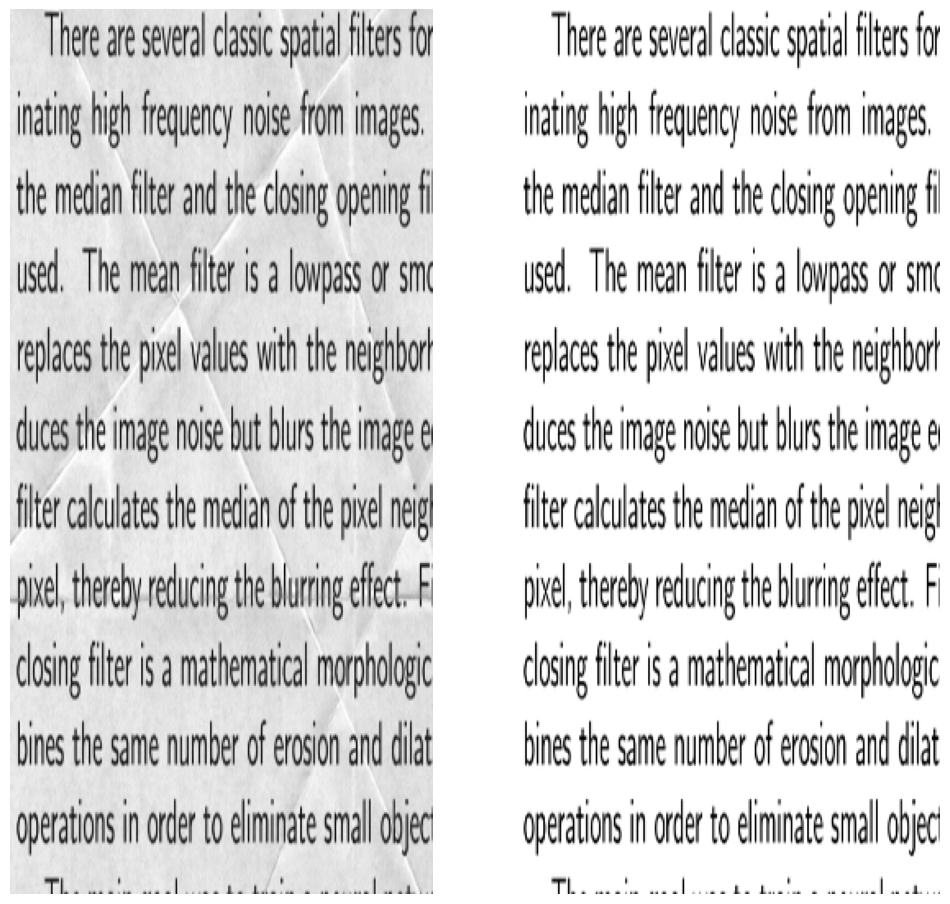

In [3]:
plt.figure(figsize=(12,12))
for img_in, img_out in zip(x_train.take(1),y_train.take(1)):
    idx=10 # indice de la imagen 

    #imagen con ruido 
    plt.subplot(1,2,1)
    plt.imshow(img_in[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

    #imagen ideal 
    plt.subplot(1,2,2)
    plt.imshow(img_out[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

In [4]:
type(x_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

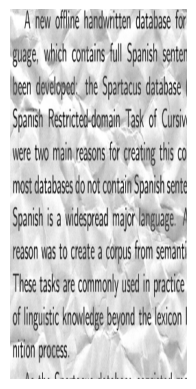

In [5]:
for imgen_test in test.take(1):
    idx=8
    plt.imshow(imgen_test[idx].numpy().astype("uint8"), cmap="gray")
    plt.axis("off")

In [6]:
print(imgen_test[idx].numpy().shape)
print(imgen_test[idx].numpy().min())
print(imgen_test[idx].numpy().max())

(540, 258, 1)
0.10464318
255.0


In [7]:
normalizacion = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x: normalizacion(x))
y_train = y_train.map(lambda x: normalizacion(x))
test = test.map(lambda x: normalizacion(x))

In [8]:
for batch1, batch2, batch3 in zip(x_train.take(1), y_train.take(1), test.take(1)):
    img1 , img2 , img3 = batch1[idx].numpy(), batch2[idx].numpy(), batch3[idx].numpy()

In [9]:
print(f'x_train: {img1.min()},{img1.max()}')
print(f'y_train: {img2.min()},{img2.max()}')
print(f'test: {img3.min()},{img3.max()}')

x_train: 0.0,0.9361554384231567
y_train: 0.0,1.0
test: 0.0004103654355276376,1.0


In [10]:
# combino los dos dataset en uno solo preservando la importancia de 1 a 1 
train = tf.data.Dataset.zip((x_train,y_train))
print(type(train))

<class 'tensorflow.python.data.ops.zip_op._ZipDataset'>


In [11]:
for x, y in (train):
    print(x.shape,y.shape)

(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(32, 540, 258, 1) (32, 540, 258, 1)
(16, 540, 258, 1) (16, 540, 258, 1)


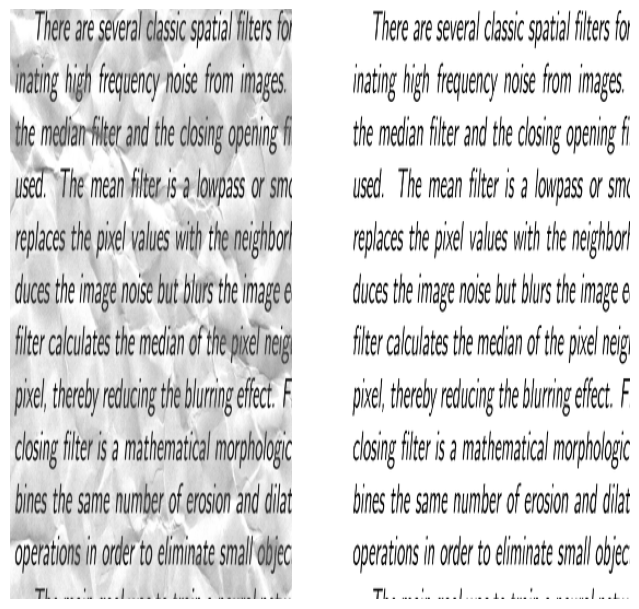

In [12]:
plt.figure(figsize=(8,8))
for X,Y in train.take(1):
    idx = 5
    x, y = X[idx], Y[idx]

    plt.subplot(1,2,1)
    plt.imshow(x.numpy(), cmap="gray")
    plt.axis("off")


    plt.subplot(1,2,2)
    plt.imshow(y.numpy(), cmap="gray")
    plt.axis("off")


AUTOENCODER

In [13]:
entrada = tf.keras.layers.Input(shape=(540,258,1), name="entrada")
#encoder
x = tf.keras.layers.Conv2D(64,(3,3),activation="relu", padding="same", name="conv_encoder")(entrada)
x = tf.keras.layers.MaxPool2D((2,2), padding="same", name="maxpool_encoder")(x)

#decoder
x = tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same", name="conv_decoder")(x)
x = tf.keras.layers.UpSampling2D((2,2), name="upsampling_decoder")(x)

salida = tf.keras.layers.Conv2D(1, (3,3), activation="sigmoid",padding="same",name="salida")(x)

#autoencoder
autoencoder = tf.keras.Model(entrada, salida)
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (InputLayer)        [(None, 540, 258, 1)]     0         
                                                                 
 conv_encoder (Conv2D)       (None, 540, 258, 64)      640       
                                                                 
 maxpool_encoder (MaxPoolin  (None, 270, 129, 64)      0         
 g2D)                                                            
                                                                 
 conv_decoder (Conv2D)       (None, 270, 129, 64)      36928     
                                                                 
 upsampling_decoder (UpSamp  (None, 540, 258, 64)      0         
 ling2D)                                                         
                                                                 
 salida (Conv2D)             (None, 540, 258, 1)       577  

In [14]:
# Verificar que la entrada y la salida son del mismo tamaño
print(f'Autoencoder - dimensiones entrada: {autoencoder.input_shape}')
print(f'Autoencoder - dimensiones salida: {autoencoder.output_shape}')

Autoencoder - dimensiones entrada: (None, 540, 258, 1)
Autoencoder - dimensiones salida: (None, 540, 258, 1)


In [15]:
autoencoder.compile(optimizer = "adam", loss = "mse")

In [16]:
autoencoder.fit(train, epochs=50)

Epoch 1/50

5/5 [==============================] - 25s 4s/step - loss: 0.1603
Epoch 2/50
5/5 [==============================] - 21s 4s/step - loss: 0.0664
Epoch 3/50
5/5 [==============================] - 21s 4s/step - loss: 0.0593
Epoch 4/50
5/5 [==============================] - 21s 4s/step - loss: 0.0633
Epoch 5/50
5/5 [==============================] - 21s 4s/step - loss: 0.0637
Epoch 6/50
5/5 [==============================] - 21s 4s/step - loss: 0.0618
Epoch 7/50
5/5 [==============================] - 21s 4s/step - loss: 0.0570
Epoch 8/50
5/5 [==============================] - 21s 4s/step - loss: 0.0538
Epoch 9/50
5/5 [==============================] - 21s 4s/step - loss: 0.0527
Epoch 10/50
5/5 [==============================] - 21s 4s/step - loss: 0.0512
Epoch 11/50
5/5 [==============================] - 21s 4s/step - loss: 0.0494
Epoch 12/50
5/5 [==============================] - 21s 4s/step - loss: 0.0470
Epoch 13/50
5/5 [==============================] - 21s 4s/step - loss: 0

In [17]:
def mostrar_imagenes(array1, array2):
    # Extraer imágenes
    n = 3 # Número de imágenes
    idx = np.random.randint(len(array1), size=n)
    imgs1 = array1[idx, :] # Imagen con ruido
    imgs2 = array2[idx, :] # Imagen predicha (reconstrucción)

    # Mostrar imágenes
    plt.figure(figsize=(20,16))
    for i, (img1, img2) in enumerate(zip(imgs1, imgs2)):
        # Mostrar imagen original (con ruido) arriba
        ax = plt.subplot(2,n,i+1)
        plt.imshow(img1, cmap='gray')
        plt.axis("off")

        # Y mostrar imagen reconstruida abajo
        plt.subplot(2,n,i+1+n)
        plt.imshow(img2, cmap='gray')
        plt.axis("off");

In [18]:
# Convertir el batch en un arreglo de NumPy y
# sobre-escribirlo
batch = x_train.take(1)
batch = np.array(list(batch.unbatch().as_numpy_iterator()))

In [19]:
# Batch de predicciones
y_pred = autoencoder.predict(batch)

# Imprimir tipos de dato
print(f'Tipos de dato batch/y_pred: {type(batch)}/{type(batch)}')
print(f'Tamaños batch/y_pred: {batch.shape}/{y_pred.shape}')

1/1 [==============================] - 1s 850ms/step
Tipos de dato batch/y_pred: <class 'numpy.ndarray'>/<class 'numpy.ndarray'>
Tamaños batch/y_pred: (32, 540, 258, 1)/(32, 540, 258, 1)


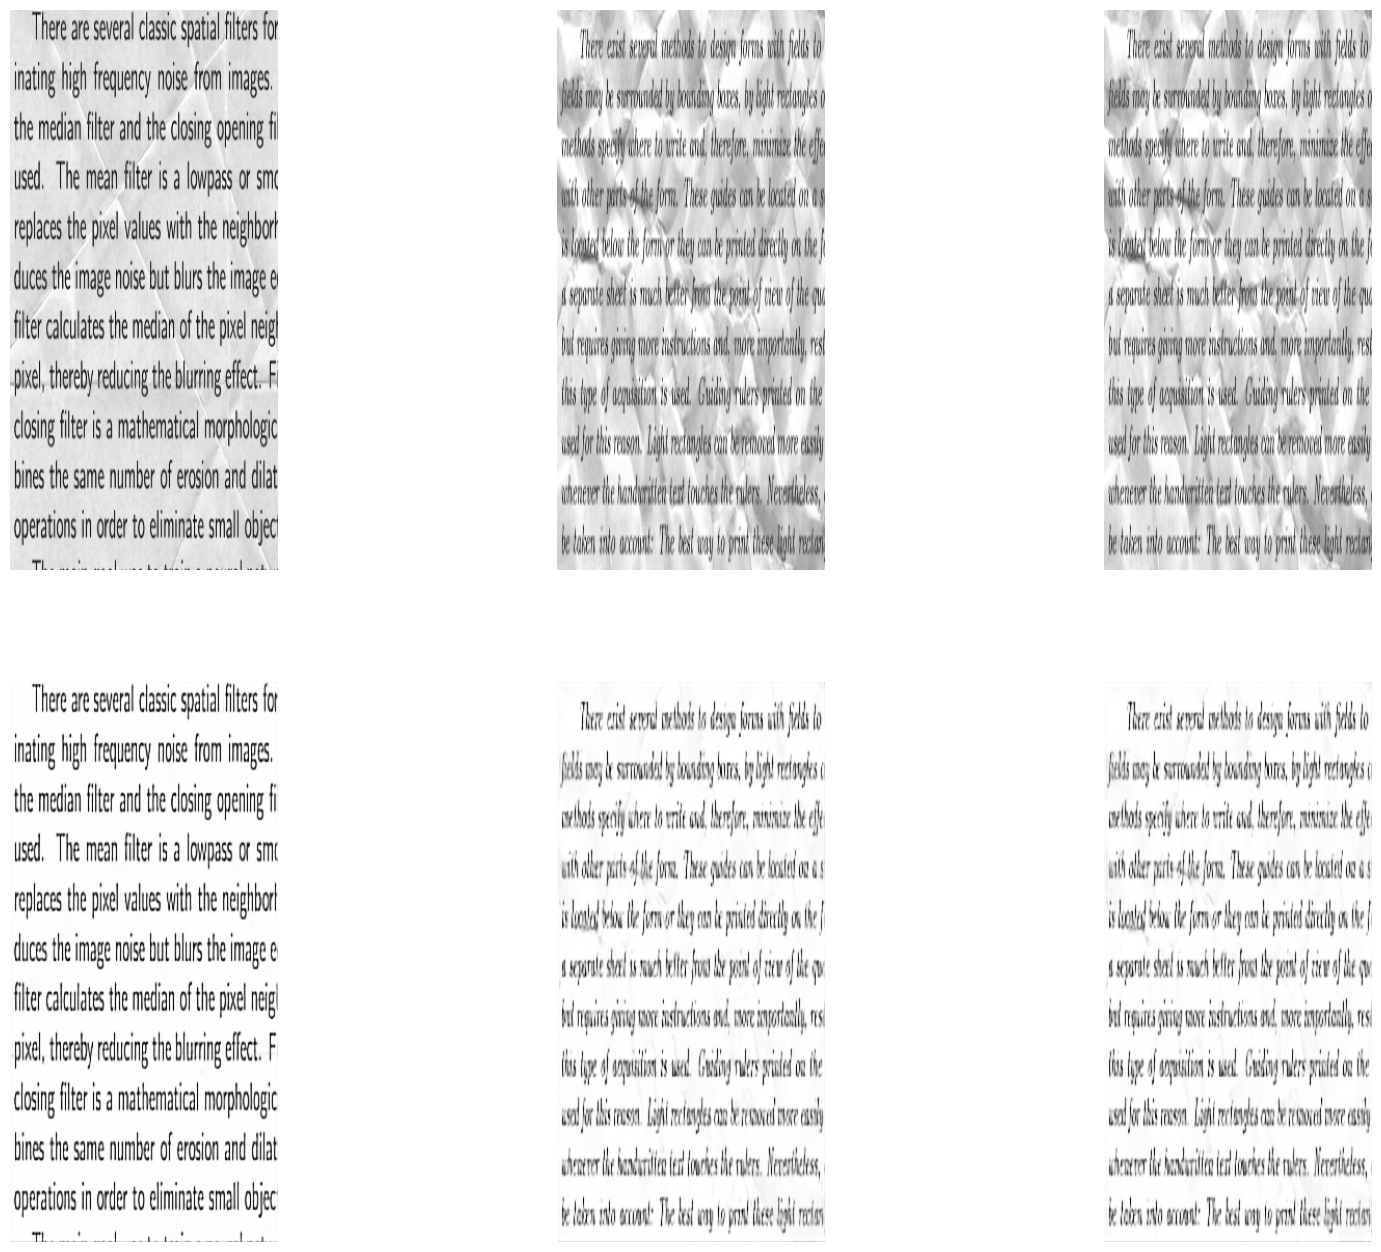

In [20]:
mostrar_imagenes(batch, y_pred)

1/1 [==============================] - 1s 702ms/step


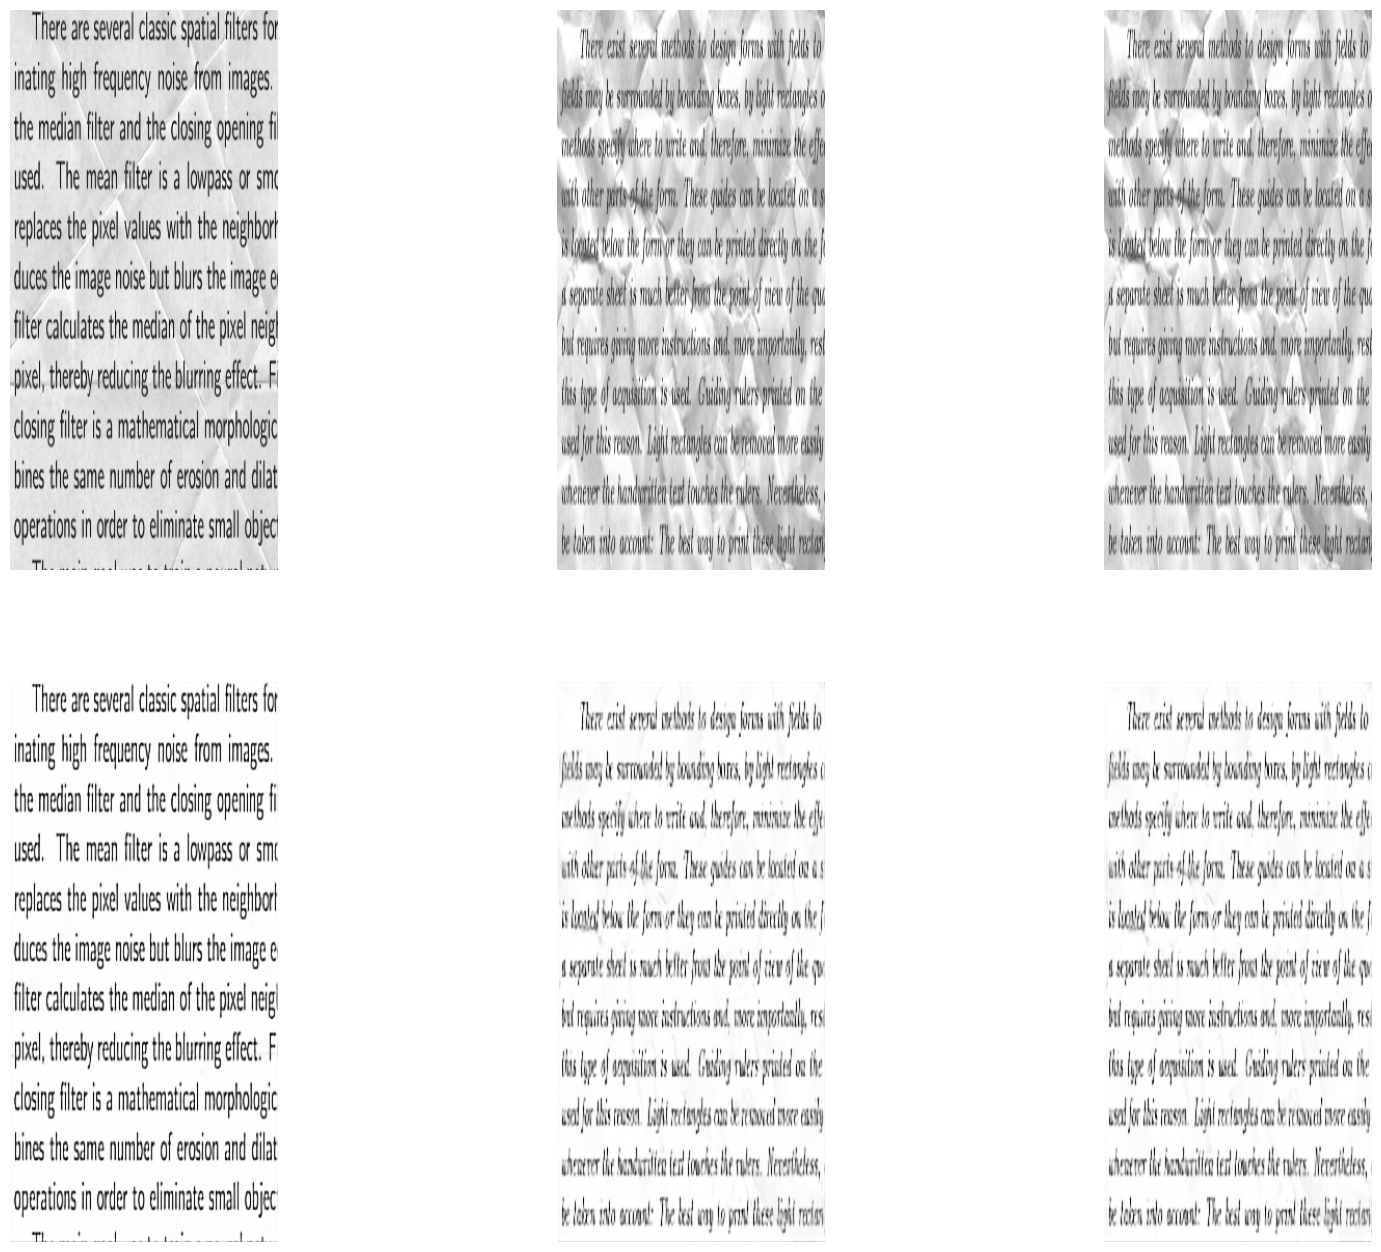

In [23]:
# Tomar un batch del set de prueba
batch = test.take(1)

# Convertir el batch a arreglo NumPy
batch = np.array(list(batch.unbatch().as_numpy_iterator()))

# Generar predicciones y visualizarlas
y_pred = autoencoder.predict(batch)
mostrar_imagenes(batch, y_pred)